Tuần 3_4: 
- tìm nguồn camera giao thông, áp dụng detect trực tiếp lên frame
- chiếu phổi cảnh để chuẩn hoá toạ độ các phương tiên trong mặt phẳng
- triển khai flask api minh hoạ trực quan
<!-- - Sử dụng model nhận dạng đường, vùng đường | output: mask vùng đường -->
<!-- - xây dựng vector di chuyển để định hướng di chuyển của các phương tiện -->


In [1]:
# Get frames livestream youtube crossroad. 

import yt_dlp
import cv2
from ultralytics import YOLO
import time
import os
import csv

# -------------------------------
# 1. Cấu hình
# -------------------------------
url = "https://www.youtube.com/watch?v=ByED80IKdIU"
save_dir = "frames"
csv_path = "vehicle_boxes.csv"
frame_interval = 2   # giây giữa 2 frame
max_frames = 100

os.makedirs(save_dir, exist_ok=True)

# -------------------------------
# 2. Chuẩn bị file CSV
# -------------------------------
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["timestamp", "frame_id", "class", "confidence", "x1", "y1", "x2", "y2", "center_x", "center_y"])

# -------------------------------
# 3. Tải model
# -------------------------------
model = YOLO("yolov8n.pt")

# -------------------------------
# 4. Lấy URL thực của livestream
# -------------------------------
ydl_opts = {"quiet": True, "format": "best"}
with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    info = ydl.extract_info(url, download=False)
    stream_url = info["url"]

# -------------------------------
# 5. Đọc video
# -------------------------------
cap = cv2.VideoCapture(stream_url)
frame_count = 0
last_capture_time = time.time()

while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        print("⚠️ Không thể đọc frame — có thể livestream tạm dừng hoặc kết thúc.")
        break

    # Cứ mỗi frame_interval giây thì xử lý 1 frame
    if time.time() - last_capture_time >= frame_interval:
        last_capture_time = time.time()
        frame_count += 1

        results = model.predict(source=frame, conf=0.25, verbose=False)

        now = time.strftime("%Y-%m-%d %H:%M:%S")

        with open(csv_path, "a", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)

            for r in results:
                for box in r.boxes:
                    cls_id = int(box.cls[0])
                    class_name = model.names[cls_id]
                    if class_name not in ["car", "motorcycle", "bus", "truck", "person"]:
                        continue

                    conf = float(box.conf[0])
                    x1, y1, x2, y2 = map(float, box.xyxy[0])
                    center_x = (x1 + x2) / 2
                    center_y = (y1 + y2) / 2

                    # Lưu từng đối tượng
                    writer.writerow([now, frame_count, class_name, conf, x1, y1, x2, y2, center_x, center_y])

        frame_path = os.path.join(save_dir, f"frame_{frame_count}.jpg")
        cv2.imwrite(frame_path, frame)
        print(f"✅ Lưu frame {frame_count} & ghi {len(results[0].boxes)} đối tượng vào CSV")

cap.release()
print("🎯 Hoàn tất trích xuất bounding box!")


✅ Lưu frame 1 & ghi 3 đối tượng vào CSV
✅ Lưu frame 2 & ghi 2 đối tượng vào CSV
✅ Lưu frame 3 & ghi 3 đối tượng vào CSV
✅ Lưu frame 4 & ghi 3 đối tượng vào CSV
✅ Lưu frame 5 & ghi 3 đối tượng vào CSV
✅ Lưu frame 6 & ghi 2 đối tượng vào CSV
✅ Lưu frame 7 & ghi 2 đối tượng vào CSV
✅ Lưu frame 8 & ghi 2 đối tượng vào CSV
✅ Lưu frame 9 & ghi 2 đối tượng vào CSV
✅ Lưu frame 10 & ghi 4 đối tượng vào CSV


KeyboardInterrupt: 

In [7]:
# trích frame từ vide file .mp4
import cv2
from ultralytics import YOLO
import time
import os
import csv

# -------------------------------
# 1. Cấu hình
# -------------------------------
video_path = "./video/test_2.mp4"   # 👉 Thay bằng đường dẫn video của bạn
save_dir = "frames_2"
csv_path = "vehicle_boxes_2.csv"
frame_interval = 2   # giây giữa 2 frame
max_frames = 6

os.makedirs(save_dir, exist_ok=True)

# -------------------------------
# 2. Chuẩn bị file CSV
# -------------------------------
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["timestamp", "frame_id", "class", "confidence", "x1", "y1", "x2", "y2", "center_x", "center_y"])

# -------------------------------
# 3. Tải model YOLO
# -------------------------------
model = YOLO("yolov8n.pt")  # hoặc yolov8s.pt nếu bạn muốn chính xác hơn

# -------------------------------
# 4. Đọc video từ file
# -------------------------------
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise Exception(f"Không thể mở video: {video_path}")

fps = cap.get(cv2.CAP_PROP_FPS)
frame_skip = int(frame_interval * fps)  # Số frame cần bỏ qua giữa mỗi lần xử lý
frame_id = 0
processed_count = 0

# -------------------------------
# 5. Vòng lặp xử lý video
# -------------------------------
while cap.isOpened() and processed_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        print("⚠️ Hết video hoặc không đọc được frame.")
        break

    if frame_id % frame_skip == 0:
        processed_count += 1
        now = time.strftime("%Y-%m-%d %H:%M:%S")

        results = model.predict(source=frame, conf=0.25, verbose=False)

        with open(csv_path, "a", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)

            for r in results:
                for box in r.boxes:
                    cls_id = int(box.cls[0])
                    class_name = model.names[cls_id]
                    if class_name not in ["car", "motorcycle", "bus", "truck", "person"]:
                        continue

                    conf = float(box.conf[0])
                    x1, y1, x2, y2 = map(float, box.xyxy[0])
                    center_x = (x1 + x2) / 2
                    center_y = (y1 + y2) / 2

                    writer.writerow([now, processed_count, class_name, conf, x1, y1, x2, y2, center_x, center_y])

        frame_path = os.path.join(save_dir, f"frame_{processed_count}.jpg")
        cv2.imwrite(frame_path, frame)
        print(f"✅ Lưu frame {processed_count} & ghi {len(results[0].boxes)} đối tượng vào CSV")

    frame_id += 1

cap.release()
print("🎯 Hoàn tất trích xuất bounding box!")



✅ Lưu frame 1 & ghi 18 đối tượng vào CSV
✅ Lưu frame 2 & ghi 14 đối tượng vào CSV
✅ Lưu frame 3 & ghi 12 đối tượng vào CSV
✅ Lưu frame 4 & ghi 18 đối tượng vào CSV
✅ Lưu frame 5 & ghi 14 đối tượng vào CSV
✅ Lưu frame 6 & ghi 18 đối tượng vào CSV
🎯 Hoàn tất trích xuất bounding box!


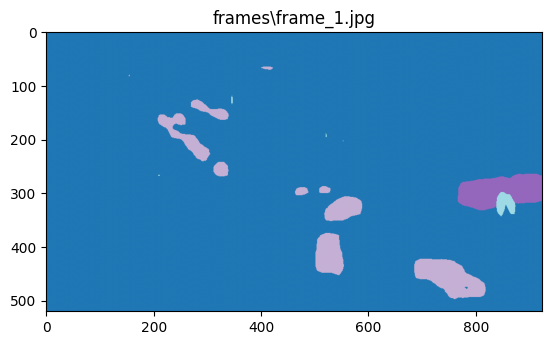

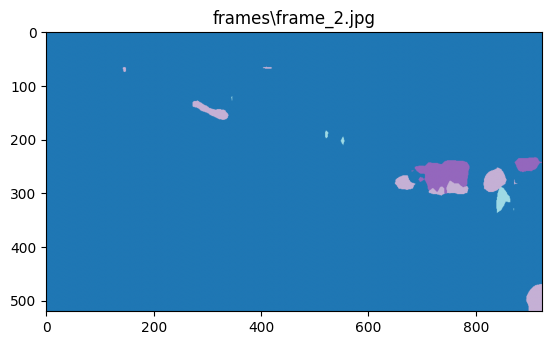

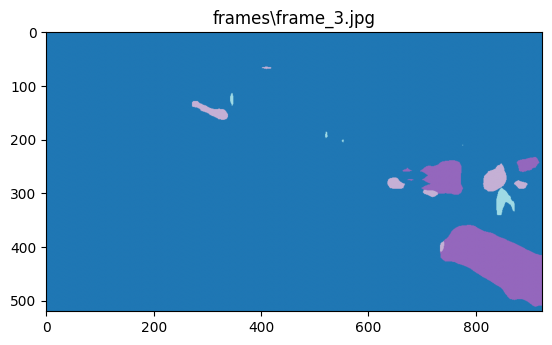

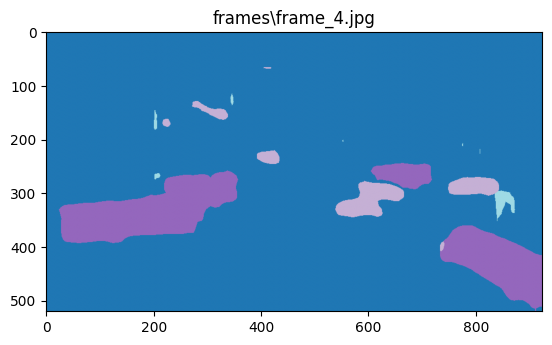

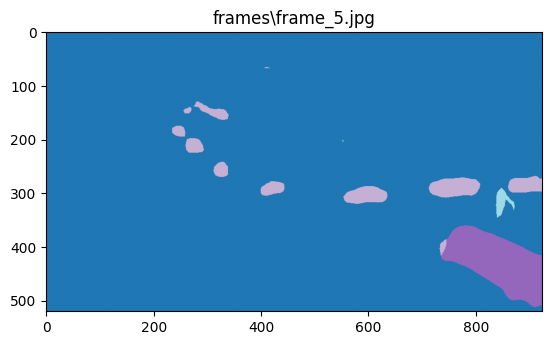

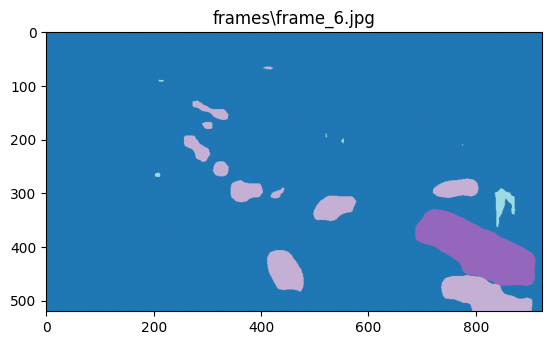

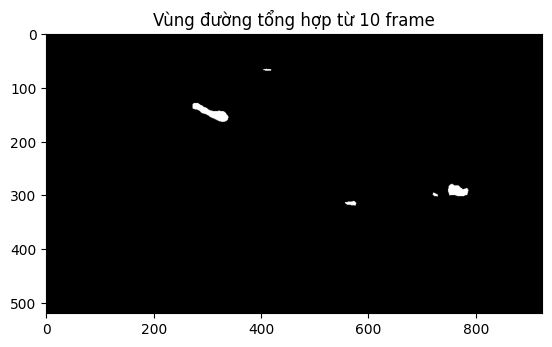

✅ Đã lưu mask tổng hợp: road_mask_combined.png


In [ ]:
# xây dựng mask road thất bại, nhưng có thể ửng dụng vào xây dựng mật độ
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# 1. Load model
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

# 2. Tiền xử lý ảnh
preprocess = transforms.Compose([
    transforms.Resize(520),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 3. Đường dẫn ảnh
frame_paths = sorted(glob.glob("frames/*.jpg"))  # hoặc *.png

masks = []  # lưu các mask nhị phân (vùng road)

# 4. Xử lý từng frame
for path in frame_paths:
    
    plt.imshow(pred, cmap='tab20')
    plt.title(path)
    plt.show()
    img = Image.open(path).convert('RGB')
    input_tensor = preprocess(img).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)['out'][0]
    pred = output.argmax(0).cpu().numpy()

    # ⚠️ class ID của "road" thường là 7 với pretrained COCO-Stuff
    mask_road = (pred == 7).astype(np.uint8)
    masks.append(mask_road)

# 5. Tổng hợp 10 mask lại (ghép / voting)
masks = np.stack(masks, axis=0)  # shape: (10, H, W)

# "đa số" - pixel được coi là đường nếu >= 50% frame nhận là road
final_mask = (np.mean(masks, axis=0) > 0.5).astype(np.uint8)

# 6. Hiển thị mask vùng đường tổng hợp
plt.imshow(final_mask, cmap='gray')
plt.title("Vùng đường tổng hợp từ 10 frame")
plt.show()

# 7. Lưu mask ra file để dùng lại
cv2.imwrite("road_mask_combined.png", final_mask * 255)
print("✅ Đã lưu mask tổng hợp: road_mask_combined.png")


In [2]:
import os
import glob
import cv2
import torch
import numpy as np
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation
import matplotlib.pyplot as plt

processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-1024-1024")
model = AutoModelForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-1024-1024").eval()

frames_dir = "frames"
output_dir = "output_frames"
os.makedirs(output_dir, exist_ok=True)

frame_paths = sorted(glob.glob(os.path.join(frames_dir, "*.jpg")))  # hoặc *.png
print(f"📸 Tổng số frame: {len(frame_paths)}")

masks = []
for i, path in enumerate(frame_paths[:10]):
    image = Image.open(path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    pred = outputs.logits.argmax(dim=1)[0].cpu().numpy()

    mask = (pred == 0).astype(np.uint8)
    mask = cv2.resize(mask, (image.width, image.height))
    masks.append(mask)

    print(f"Frame {i+1}: tạo mask road ({os.path.basename(path)})")

masks = np.stack(masks, axis=0)
mean_mask = np.mean(masks, axis=0)
road_mask = (mean_mask > 0.3).astype(np.uint8)

# kernel = np.ones((5,5), np.uint8)
# road_mask = cv2.morphologyEx(road_mask, cv2.MORPH_CLOSE, kernel)
# road_mask = cv2.morphologyEx(road_mask, cv2.MORPH_OPEN, kernel)


# --- Sau khi tạo road_mask ban đầu ---
kernel = np.ones((5,5), np.uint8)
road_mask = cv2.morphologyEx(road_mask, cv2.MORPH_CLOSE, kernel)
road_mask = cv2.morphologyEx(road_mask, cv2.MORPH_OPEN, kernel)

# ⚙️ Bước 1: làm dày vùng đường để nối các khe nhỏ
road_mask = cv2.dilate(road_mask, np.ones((9,9), np.uint8), iterations=1)

# ⚙️ Bước 2: chỉ giữ vùng connected lớn nhất (bỏ rác xung quanh)
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(road_mask, connectivity=8)
if num_labels > 1:
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # bỏ nhãn nền 0
    road_mask = (labels == largest_label).astype(np.uint8)

# ⚙️ Bước 3: làm mượt vùng đường
road_mask = cv2.GaussianBlur(road_mask.astype(np.float32), (11, 11), 0)
road_mask = (road_mask > 0.2).astype(np.uint8)

# ⚙️ Bước 4 (tùy chọn): dùng HoughLinesP để nối các đoạn đường thẳng rõ nét
edges = cv2.Canny((road_mask * 255).astype(np.uint8), 50, 150, apertureSize=3)
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=80, minLineLength=50, maxLineGap=30)

if lines is not None:
    h, w = road_mask.shape
    line_mask = np.zeros((h, w), np.uint8)
    for l in lines:
        x1, y1, x2, y2 = l[0]
        cv2.line(line_mask, (x1, y1), (x2, y2), 1, thickness=8)
    # Kết hợp đường thẳng với mask hiện tại
    road_mask = cv2.bitwise_or(road_mask, line_mask)

# ⚙️ Bước 5: làm đầy lại để vùng đường liền mạch
road_mask = cv2.morphologyEx(road_mask, cv2.MORPH_CLOSE, np.ones((15,15), np.uint8))
road_mask = cv2.morphologyEx(road_mask, cv2.MORPH_OPEN, np.ones((7,7), np.uint8))

cv2.imwrite("road_mask_refined.png", road_mask * 255)
print("✅ Đã tinh chỉnh mask đường liền mạch hơn (road_mask_refined.png)")

for path in frame_paths:
    frame = cv2.imread(path)
    overlay = frame.copy()
    overlay[road_mask == 1] = (0, 255, 0) 
    highlight = cv2.addWeighted(overlay, 0.4, frame, 0.6, 0)

    output_path = os.path.join(output_dir, os.path.basename(path))
    cv2.imwrite(output_path, highlight)
    print(f"✅ Đã tạo ảnh highlight: {output_path}")

print("🎯 Hoàn tất: mask và ảnh highlight đã được lưu trong thư mục output_frames/")

c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next run

📸 Tổng số frame: 10
Frame 1: tạo mask road (frame_1.jpg)
Frame 2: tạo mask road (frame_10.jpg)
Frame 3: tạo mask road (frame_2.jpg)
Frame 4: tạo mask road (frame_3.jpg)
Frame 5: tạo mask road (frame_4.jpg)
Frame 6: tạo mask road (frame_5.jpg)
Frame 7: tạo mask road (frame_6.jpg)
Frame 8: tạo mask road (frame_7.jpg)
Frame 9: tạo mask road (frame_8.jpg)
Frame 10: tạo mask road (frame_9.jpg)
✅ Đã tinh chỉnh mask đường liền mạch hơn (road_mask_refined.png)
✅ Đã tạo ảnh highlight: output_frames\frame_1.jpg
✅ Đã tạo ảnh highlight: output_frames\frame_10.jpg
✅ Đã tạo ảnh highlight: output_frames\frame_2.jpg
✅ Đã tạo ảnh highlight: output_frames\frame_3.jpg
✅ Đã tạo ảnh highlight: output_frames\frame_4.jpg
✅ Đã tạo ảnh highlight: output_frames\frame_5.jpg
✅ Đã tạo ảnh highlight: output_frames\frame_6.jpg
✅ Đã tạo ảnh highlight: output_frames\frame_7.jpg
✅ Đã tạo ảnh highlight: output_frames\frame_8.jpg
✅ Đã tạo ảnh highlight: output_frames\frame_9.jpg
🎯 Hoàn tất: mask và ảnh highlight đã được 

**Trực quan hoá bằng scatter**

In [28]:
# test
import os
import cv2
import pandas as pd
import numpy as np

# -----------------------------
# 1️⃣ Cấu hình ban đầu
# -----------------------------
frames_dir = "frames"
output_dir = "map_frames"
os.makedirs(output_dir, exist_ok=True)

# Đọc mask refined
road_mask = cv2.imread("road_mask_refined.png", cv2.IMREAD_GRAYSCALE)
road_mask = cv2.resize(road_mask, (1920, 1080))  # điều chỉnh tùy theo kích thước frame thực tế
road_mask_color = cv2.cvtColor(road_mask, cv2.COLOR_GRAY2BGR)
road_mask_color = (road_mask_color > 128).astype(np.uint8) * np.array([0, 180, 0], np.uint8)  # xanh lá nhẹ

# Đọc file CSV chứa bounding boxes
df = pd.read_csv("vehicle_boxes.csv")

# Lọc chỉ những class quan tâm
target_classes = ["car", "motorcycle", "bus", "truck", "person"]
df = df[df["class"].isin(target_classes)]

# Kích thước hiển thị tương ứng theo class
class_size = {
    "person": 2,
    "motorcycle": 3,
    "car": 4,
    "truck": 6,
    "bus": 8
}

# Màu hiển thị theo class (BGR)
class_color = {
    "person": (0, 0, 255),       # đỏ
    "motorcycle": (255, 0, 0),   # xanh dương
    "car": (0, 255, 255),        # vàng
    "truck": (0, 128, 255),      # cam
    "bus": (0, 255, 0)           # xanh lá tươi
}

# -----------------------------
# 2️⃣ Tạo map cho từng frame
# -----------------------------
for frame_path in sorted(os.listdir(frames_dir)):
    if not frame_path.endswith(".jpg"):
        continue

    frame_id = int(os.path.splitext(frame_path)[0].split("_")[-1])  # ví dụ frame_23.jpg -> 23
    frame = cv2.imread(os.path.join(frames_dir, frame_path))

    # Overlay road mask nhẹ (highlight vùng đường)
    overlay = frame.copy()
    overlay[road_mask > 0] = (overlay[road_mask > 0] * 0.6 + road_mask_color[road_mask > 0] * 0.4).astype(np.uint8)
    blended = cv2.addWeighted(frame, 0.7, overlay, 0.3, 0)

    # Lọc dữ liệu thuộc frame này
    frame_objects = df[df["frame_id"] == frame_id]

    # Vẽ các điểm phương tiện
    for _, row in frame_objects.iterrows():
        cls = row["class"]
        cx, cy = int(row["center_x"]), int(row["center_y"])
        size = class_size.get(cls, 3)
        color = class_color.get(cls, (255, 255, 255))

        cv2.circle(blended, (cx, cy), size * 2, color, -1)
        # Có thể thêm nhãn nếu muốn:
        cv2.putText(blended, cls[0].upper(), (cx+5, cy-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

    # Lưu kết quả
    output_path = os.path.join(output_dir, f"map_{frame_id:04d}.jpg")
    cv2.imwrite(output_path, blended)
    print(f"✅ Tạo map frame {frame_id}: {output_path}")

print("🎯 Hoàn tất: Các bản đồ traffic map đã được lưu trong thư mục map_frames/")


✅ Tạo map frame 1: map_frames\map_0001.jpg
✅ Tạo map frame 2: map_frames\map_0002.jpg
✅ Tạo map frame 3: map_frames\map_0003.jpg
✅ Tạo map frame 4: map_frames\map_0004.jpg
✅ Tạo map frame 5: map_frames\map_0005.jpg
✅ Tạo map frame 6: map_frames\map_0006.jpg
🎯 Hoàn tất: Các bản đồ traffic map đã được lưu trong thư mục map_frames/


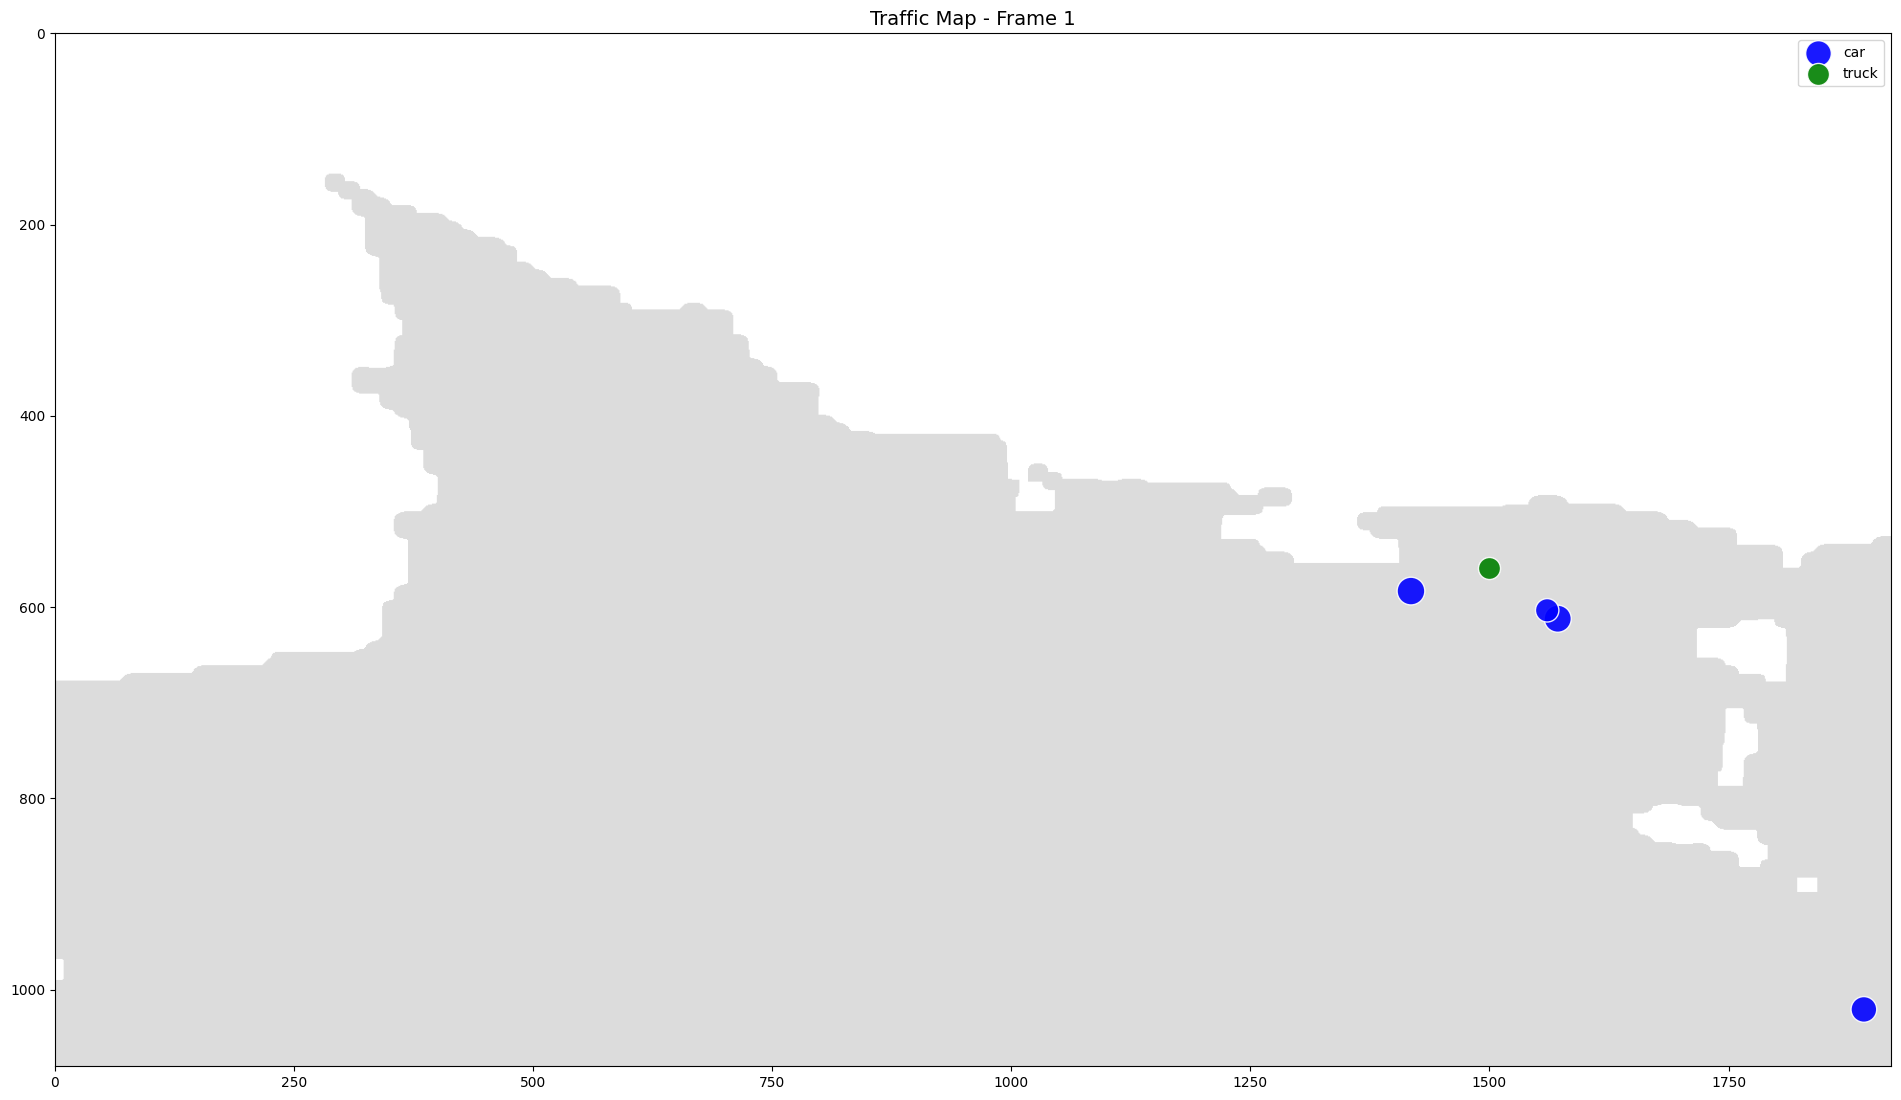

FileNotFoundError: [Errno 2] No such file or directory: 'map_scatter/frame_0001.png'

<Figure size 640x480 with 0 Axes>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

# -------------------------------
# 1️⃣ Đọc dữ liệu
# -------------------------------
df = pd.read_csv("vehicle_boxes.csv")

# Chỉ lấy các class quan tâm
vehicle_classes = ['car', 'motorcycle', 'bus', 'truck', 'person']
vehicle_df = df[df['class'].isin(vehicle_classes)].copy()

# Tính tọa độ trung tâm bbox
vehicle_df['center_x'] = (vehicle_df['x1'] + vehicle_df['x2']) / 2
vehicle_df['center_y'] = (vehicle_df['y1'] + vehicle_df['y2']) / 2

# -------------------------------
# 2️⃣ Đọc road mask để làm nền
# -------------------------------
road_mask = cv2.imread("road_mask_refined.png", cv2.IMREAD_GRAYSCALE)
if road_mask is None:
    raise FileNotFoundError("❌ Không tìm thấy file road_mask_refined.png")

h, w = road_mask.shape
road_mask_rgb = cv2.cvtColor(road_mask, cv2.COLOR_GRAY2RGB)
road_mask_rgb = np.where(road_mask_rgb > 128, 220, 255).astype(np.uint8)  # nền sáng, đường xám nhạt

# -------------------------------
# 3️⃣ Vẽ scatter plot
# -------------------------------
color_map = {
    'car': 'blue',
    'truck': 'green',
    'bus': 'orange',
    'motorcycle': 'red',
    'person': 'purple'
}

# Duyệt từng frame
for frame_id in sorted(vehicle_df["frame_id"].unique()):
    frame_data = vehicle_df[vehicle_df["frame_id"] == frame_id]

    fig, ax = plt.subplots(figsize=(w/100, h/100))
    
    # Nền road mask
    ax.imshow(road_mask_rgb, extent=[0, w, h, 0])
    
    # Các phương tiện
    for v_class, data in frame_data.groupby("class"):
        ax.scatter(
            data["center_x"], data["center_y"],
            c=color_map.get(v_class, "black"),
            label=v_class,
            s = data['confidence'] * 1000,
            alpha=0.9,
            edgecolors='white'
        )

    # Định dạng trục
    ax.set_xlim(0, w)
    ax.set_ylim(0, h)
    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')
    ax.legend(loc='upper right')
    ax.set_title(f"Traffic Map - Frame {frame_id}", fontsize=14)

    plt.tight_layout(pad=0)
    plt.show()
    # Hoặc lưu nếu cần:
    plt.savefig(f"map_scatter/frame_{frame_id:04d}.png", dpi=150)
    plt.close(fig)


In [ ]:
[
    np.array([[244, 274], [564, 270]]),
    np.array([[718, 977], [1668, 847]])
]

In [6]:
import pandas as pd
import numpy as np
import cv2
import io

# --- 1. Chuẩn bị dữ liệu ---
# Dữ liệu bounding box của các phương tiện
csv_data = """timestamp,frame_id,class,confidence,x1,y1,x2,y2,center_x,center_y
2025-10-17 14:47:15,1,car,0.8689222931861877,471.1004638671875,347.34307861328125,601.2760009765625,404.24261474609375,536.188232421875,375.7928466796875
2025-10-17 14:47:15,1,car,0.8507338762283325,1069.08740234375,323.9072265625,1186.06298828125,368.37493896484375,1127.5751953125,346.1410827636719
2025-10-17 14:47:15,1,car,0.8332301378250122,372.28656005859375,416.2896728515625,531.8116455078125,470.2647705078125,452.0491027832031,443.2772216796875
2025-10-17 14:47:15,1,car,0.7583964467048645,1138.113037109375,350.7173156738281,1277.228759765625,423.9996032714844,1207.6708984375,387.35845947265625
2025-10-17 14:47:15,1,car,0.7070091366767883,610.7156982421875,167.63174438476562,657.7249755859375,193.93417358398438,634.2203369140625,180.782958984375
2025-10-17 14:47:15,1,car,0.640680730342865,980.9049682617188,526.8892211914062,1271.282470703125,588.4622192382812,1126.0937194824219,557.6757202148438
2025-10-17 14:47:15,1,motorcycle,0.4301404654979706,926.916748046875,357.03607177734375,980.298828125,397.89910888671875,953.6077880859375,377.46759033203125
2025-10-17 14:47:15,1,car,0.4477916359901428,622.5914306640625,276.99920654296875,673.3739013671875,316.21124267578125,647.982666015625,296.605224609375
"""
df = pd.read_csv(io.StringIO(csv_data))

# Lọc dữ liệu cho frame 1 và chỉ lấy các phương tiện cần thiết
frame_df = df[(df['frame_id'] == 1) & (df['class'].isin(['car', 'motorcycle']))].copy()

# --- 2. Thiết lập phép biến đổi phối cảnh ---

# 4 điểm nguồn trên ảnh gốc (theo tọa độ pixel)
# Tương ứng với: [top-left, top-right, bottom-left, bottom-right] của hình chữ nhật trong thực tế
pts_src = np.array([
    [244, 274], 
    [564, 270], 
    [718, 977], 
    [1668, 847]
], dtype=np.float32)

# Kích thước của hình chữ nhật trong thực tế (đơn vị: mét)
# Giả sử đoạn đường này rộng 15 mét và dài 40 mét
REAL_WORLD_WIDTH_METERS = 15.0
REAL_WORLD_HEIGHT_METERS = 40.0

# 4 điểm đích tương ứng trên mặt phẳng thực tế
pts_dst = np.array([
    [0, 0],
    [REAL_WORLD_WIDTH_METERS, 0],
    [0, REAL_WORLD_HEIGHT_METERS],
    [REAL_WORLD_WIDTH_METERS, REAL_WORLD_HEIGHT_METERS]
], dtype=np.float32)

# Tính toán ma trận biến đổi M
M = cv2.getPerspectiveTransform(pts_src, pts_dst)
print("Ma trận biến đổi phối cảnh (M):")
print(M)
print("-" * 30)

# --- 3. Áp dụng phép biến đổi để lấy tọa độ thực tế ---

real_world_coords = []
for index, row in frame_df.iterrows():
    # Lấy điểm trung tâm ở cạnh dưới của bounding box (điểm tiếp xúc mặt đường)
    bottom_center_x = (row['x1'] + row['x2']) / 2
    bottom_center_y = row['y2']
    
    # Tạo điểm dưới dạng ma trận numpy để OpenCV xử lý
    # Cấu trúc bắt buộc là (1, 1, 2)
    point_in_image = np.array([[[bottom_center_x, bottom_center_y]]], dtype=np.float32)
    
    # Áp dụng phép biến đổi
    point_in_real_world = cv2.perspectiveTransform(point_in_image, M)
    
    # Lấy tọa độ x, y từ kết quả
    real_x = point_in_real_world[0][0][0]
    real_y = point_in_real_world[0][0][1]
    
    real_world_coords.append({
        'class': row['class'],
        'confidence': row['confidence'],
        'real_x_meters': real_x,
        'real_y_meters': real_y
    })

# Chuyển kết quả thành DataFrame của Pandas để dễ xem
results_df = pd.DataFrame(real_world_coords)

# --- 4. Hiển thị kết quả ---
print("Tọa độ của các phương tiện trên mặt phẳng thực tế (Frame 1):")
print(results_df)

Ma trận biến đổi phối cảnh (M):
[[    -1.4965       1.009      88.672]
 [  -0.087611     -7.0088      1941.8]
 [  0.0038606      -0.131           1]]
------------------------------
Tọa độ của các phương tiện trên mặt phẳng thực tế (Frame 1):
        class  confidence  real_x_meters  real_y_meters
0         car    0.868922       6.130520      18.811399
1         car    0.850734      28.598143      17.220915
2         car    0.833230       1.924997      23.679712
3         car    0.758396      25.875435      22.768225
4         car    0.707009      30.273598     -23.999928
5         car    0.640681      13.976634      31.798050
6  motorcycle    0.430140      19.746933      19.613522
7         car    0.447792      14.818206       8.734624
